In [1]:
import uuid
from dotenv import load_dotenv
from modules import logging
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.schema import BaseMessage
from typing_extensions import Annotated, Literal, Sequence, TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import pprint
from langchain_core.runnables import RunnableConfig

In [2]:
# LangSmith Logging
logging.langsmith("Model_RAG")
# API 키 정보 로드
load_dotenv()

LangSmith 추적을 시작합니다.
[프로젝트명]
Model_RAG


True

In [3]:
session_id = str(uuid.uuid4())
memory = MemorySaver()

In [4]:
ollama_embeddings = OllamaEmbeddings(
    model="nomic-embed-text"
)

loaded_db = FAISS.load_local(
    folder_path="faiss_db",
    index_name="meritz_index",
    embeddings=ollama_embeddings,
    allow_dangerous_deserialization=True,
)

C:\Users\vkxql\AppData\Local\Temp\ipykernel_4224\4185708034.py:1: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  ollama_embeddings = OllamaEmbeddings(


In [5]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [6]:
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=loaded_db.as_retriever(),
    llm=llm
)

In [7]:
class state(TypedDict):
    # 메시지 관리 (사용자와 시스템의 대화 기록)
    messages: Annotated[Sequence[BaseMessage], "add_messages"]
    # 세션 ID (각 워크플로우 인스턴스에 고유한 ID)
    session_id: str
    # 기타 메타데이터 (사용자 정보, 소스 등)
    metadata: dict
    # 검색된 문서 리스트
    retrieved_docs: dict  # 검색 결과 (MultiQueryRetriever의 반환 값)
    # 등급
    document_grading: list
    
    insurance_grading : list
    # 재 생성 된 답변
    rewritten_question : list
    # 생성된 최종 답변
    generated_response: str  # 시스템의 최종 답변

In [8]:
# Agent 노드

def agent(state: state) -> state:
    """
    The agent must respond appropriately to the user's questions based on the modified status {state}. Follow these steps:
    """
    
    agent_prompt = f"""
    The agent must respond appropriately to the user's questions based on the modified status {state}. Follow these steps:
    # Step

    1. **Analyze questions**: Analyze the questions you have presented to determine if they are about auto insurance.
    2. **Use a retriever**: If you're asking questions about car insurance, move to use a retriever to perform an information search.
    3. **Process another question**: If that question is not related to car insurance, end the process by answering "This is an unanswerable question."
    4. **The generation of final answers is handled by the answer generation node, so if it is a related question, please go to the retriever and do not answer separately.

    # Output Format

    - If you are inquiring about car insurance: a question about insurance.
    - If it's not related to car insurance: "It's an unanswerable question."

    # Example

    For example:
    - **Enter**: "How's the weather today?"
    - **Output**: "It's an unanswerable question."

    # Note

    - Always make clear judgments about the content of your questions and make sure they are related to your car insurance first.
    - Accurate and clear information delivery is important, and care must be taken not to include unnecessary information.

    Args:
    Status (message): current status

    Respond with:
    - "relevance" if the question is related to insurance.
    - "Unrelated" if the question is not related to insurance.
    """
    
    print("---CALL AGENT---")
    messages = state["messages"]
    # rewritten_question = state.get(["rewritten_question"], None)
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    
    result = llm(agent_prompt)
    state["insurance_grading"] = result    
    # model = model.bind_tools(tools)
    response = model.invoke(messages)
    # print("State contents:", state)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [9]:
def retriever_tool(state:state) -> state:
    """
    It's a multi-query retriever tool
    Retrieves documents using MultiQueryRetriever based on the current question.
    """
    print("---CALL RETRIEVE TOOL---")
    
    # 사용자의 마지막 질문 또는 rewritten_question이 있는 경우 해당 값을 사용
    # user_question = state["messages"][-1]["content"]
    messages = state["messages"]
    user_question = messages[-1]
    
    # MultiQueryRetriever에 사용할 프롬프트
    multi_query_prompt = f"""
    You are an expert assistant trained to optimize search queries for retrieving the most relevant documents.
    Given a user question, your task is to generate multiple rephrased versions of the same question. These
    rephrased questions should:
    
    1. Cover different ways a user might phrase the same question.
    2. Maintain the original intent and meaning of the question.
    3. Use synonyms, structural variations, and alternative expressions where applicable.

    For the following user question, generate at least **5 rephrased versions**:
    
    Original Question:
    "{user_question}"
    
    Ensure your rephrased versions are concise, clear, and ready to be used in a search query. Output the rephrased questions as a list.
    """
    
    # MultiQueryRetriever로 문서 검색
    retrieved_docs = multi_query_retriever.get_relevant_documents(multi_query_prompt)
    
    # 검색된 문서를 상태에 저장
    state["retrieved_docs"] = retrieved_docs
    return state

In [10]:
def grade_documents(state: state) -> state:
    """
    Grades the retrieved documents to determine relevance to the user's question.
    """
    print("---GRADE DOCUMENTS NODE ACTIVATED---")
    
    retrieved_docs = state.get("retrieved_docs", [])
    user_question = state["messages"][-1]
    # ["content"]
    
    grading_prompt = f"""
    You are an expert in evaluating document relevance. Given the user's question and the retrieved documents,
    evaluate whether the documents are relevant or Not Relevant.

    User Question:
    "{user_question}"

    Retrieved Documents (Summarized):
    {retrieved_docs}

    Respond with:
    - "Relevant" if the documents are relevant to the question.
    - "Not Relevant" if the documents are not relevant.
    """
    
    # LLM 평가
    relevance_result = llm(grading_prompt)
    state["document_grading"] = relevance_result
    print(f"Document Grading: {state['document_grading']}")
    return state

In [11]:
# 조건부 연결 추가
def conditional_decision(state: state) -> state:
    """
    조건부 경로를 결정하는 함수.
    'grade_documents' 결과에 따라 경로가 나뉨.
    """
    if state.get("document_grading") == "relevant":
        return "generate"
    else:
        return "rewrite"

In [12]:
# 조건부 연결 추가
def conditional_retriever(state: state) -> state:
    """
    조건부 경로를 결정하는 함수.
    'insurance_grading' 결과에 따라 경로가 나뉨.
    """
    if state.get("insurance_grading") == "relevance":
        return "retriever"
    
    if state.get("insurance_grading") == "Unrelated":
        return END

In [13]:
def rewrite(state: state) -> state:
    """
    Generates a new question if the retrieved documents are not relevant.
    """
    print("---REWRITE NODE ACTIVATED---")
    
    user_question = state["messages"][-1]
    rewrite_prompt = f"""
    The retrieved documents were not relevant to the following user question:
    "{user_question}"
    
    Please analyze the user's intent and generate a new question that better represents the user's intent
    to find relevant documents. Ensure the new question is concise and clear.
    """
    
    # LLM을 사용하여 질문 재작성
    rewritten_question = llm(rewrite_prompt)
    state["rewritten_question"] = rewritten_question
    print(f"Rewritten Question: {state['rewritten_question']}")
    # if rewritten_question:
    #     response = llm.invoke(rewritten_question)
    #     print(f"Rewritten Question: {state['rewritten_question']}")
    #     return {"messages": [response]}
    
    return state

In [14]:
def generate(state: state) -> state:
    """
    The node that generates the answer
    Generates the final response based on the user's question and relevant documents.
    """
    print("---GENERATE RESPONSE NODE ACTIVATED---")
    
    user_question = state["messages"][-1]
    retrieved_docs = state["retrieved_docs"]
    
    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)
    
    response_prompt = f"""
    User Question:
    "{user_question}"
    
    Relevant Documents:
    {retrieved_docs}
    
    Generate a concise and accurate response to the user's question based on the provided information.
    Ensure the response directly addresses the question without adding unnecessary details. Focus on clarity and accuracy when interpreting the information and constructing the reply.

    # Steps

    1. Read and understand the user's question to identify the key components and what needs to be addressed.
    2. Review the provided information carefully to ensure no important details are overlooked.
    3. Interpret the information in the context of the question.
    4. Construct a clear and concise response that directly answers the user's question, ensuring all necessary aspects are covered.

    # Output Format

    The response should be a short paragraph or bullet points, depending on the complexity and nature of the question. Aim for brevity and clarity.
    """
    
    
    # LLM을 사용하여 최종 답변 생성
    generated_response = llm(response_prompt)
    state["generated_response"] = generated_response
    print(f"Generated Response: {state['generated_response']}")
    
    rag_chain = generated_response | StrOutputParser()
    
    response = rag_chain.invoke({"context": retrieved_docs, "question": user_question})
    return {"messages": [response]}


In [15]:
workflow = StateGraph(state)

In [16]:
workflow.add_node("agent", agent)
workflow.add_node("retriever", retriever_tool)
workflow.add_node("grade", grade_documents)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

In [17]:
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    conditional_retriever,
    {
        "relevance": "retriever",
        "Unrelated": END,
    }
)
# workflow.add_edge("agent", "retriever")
workflow.add_edge("retriever", "grade")
workflow.add_conditional_edges(
    "grade",
    # Assess agent decision
    conditional_decision,
    {
        "relevant": "generate",
        "not_relevant": "rewrite",
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

In [18]:
graph = workflow.compile(checkpointer=memory)

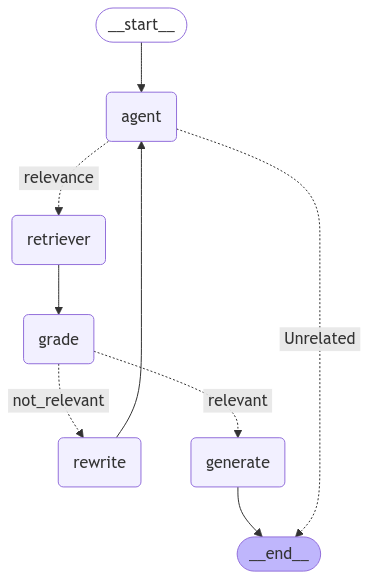

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
import pprint

# 입력 데이터 정의
inputs = {
    "messages": [
        ("user", "대인 부분 보장 범위에 대해 알려줘."),
    ]
}

# Configurable 설정 (필요한 경우)
config = {"configurable": {"thread_id": "user_123"}}


In [21]:
ddd

NameError: name 'ddd' is not defined

In [22]:
# 그래프 스트림 실행
for output in graph.stream(inputs, config=config):
    # 각 노드의 출력 처리
    for key, value in output.items():
        print(f"\n{'-'*10} Output from node '{key}' {'-'*10}\n")
        
        # 메시지가 포함된 경우만 출력
        if "messages" in value:
            for message in value["messages"]:
                if hasattr(message, "content") and message.content:
                    print(f"**Message Content**:\n{message.content}\n")
        else:
            pprint.pprint(value, indent=2, width=80, depth=None)
        
        print("\n" + "-"*30 + "\n")

---CALL AGENT---


C:\Users\vkxql\AppData\Local\Temp\ipykernel_4224\959166295.py:46: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = llm(agent_prompt)


KeyError: None

In [ ]:
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

In [41]:
from modules.messages import _display_message_tree

In [ ]:
_display_message_tree(output)